## Analiza danych

#### Przegląd atrybutów

In [76]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

sys.path.append(str(Path("..").resolve()))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from src.transformations.sessions import *

sessions = pd.read_csv("../data/raw/sessions.csv")
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976183 entries, 0 to 976182
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   action            976183 non-null  object 
 1   user_id           976183 non-null  int64  
 2   timestamp         976183 non-null  object 
 3   listing_id        904250 non-null  float64
 4   booking_date      71933 non-null   object 
 5   booking_duration  71933 non-null   float64
 6   booking_id        74853 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 52.1+ MB


#### Wybór atrybutów 
Do utworzenia nowych, zagregowanych kolumną posłużą wszystkie atrybuty. Nowe kolumnę będą reprezentowały zachowanie użytkowników mogące wskazywać na realny popyt, który powinien mieć wpływ na cenę. (później zostanie przeprowadzona analiza wtórna, aby ewentualnie wykluczyć zbędnie utworzone kolumny)

Lista zastosowanych transformacji znajduje się w *transformations/sessions.py*.

#### Czyszczenie wstępne

- *action* jako kolumna decyzyjna

In [78]:
sessions["action"].value_counts()

action
view_listing       829397
browse_listings     71933
book_listing        71933
cancel_booking       2920
Name: count, dtype: int64

Rekordów, dla których akcja to *browse_listings*, nie da się połączyć z konkretnymi *listing_id*, dlatego zostaną one odrzucone. 

In [79]:
sessions = drop_browse_listings(sessions)
sessions["action"].value_counts()

action
view_listing      829397
book_listing       71933
cancel_booking      2920
Name: count, dtype: int64

- rekordy starsze niż 1 rok

Sytuacja na rynku wynajmu krótkoterminowego jest bardzo dynamiczna, dlatego aby ograniczyć dryf danych oraz ich zaszumienie, na wstępnie odrzucone zostaną rekordy starsze niż **1 rok**. 

In [80]:
sessions, newest_timestamp = get_newest_timestamp(sessions)
newest_timestamp

Timestamp('2024-12-02 17:14:31.519819')

In [81]:
sessions = drop_records_older_than_one_year(sessions, newest_timestamp)
sessions["action"].value_counts()

action
view_listing      133834
book_listing       11553
cancel_booking       579
Name: count, dtype: int64

- rozkład danych w ostatnim roku

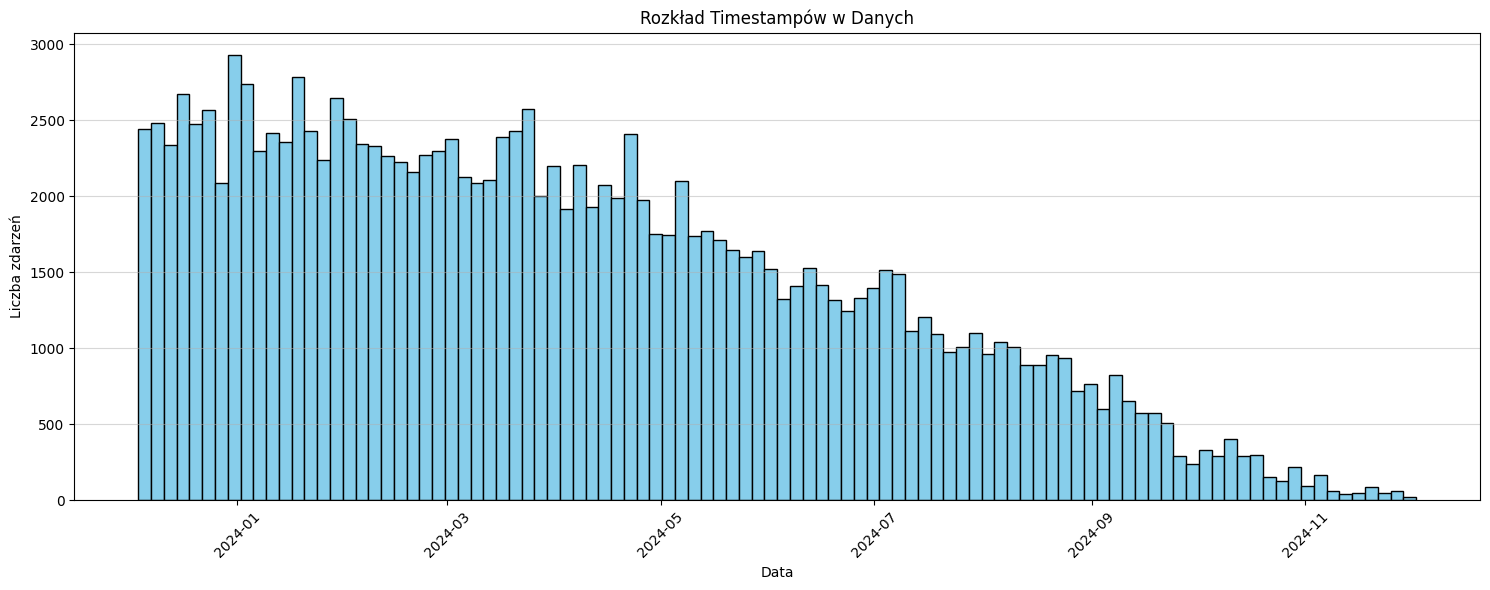

In [82]:
sessions["timestamp"] = pd.to_datetime(sessions["timestamp"], errors="coerce")
valid_dates = sessions["timestamp"].dropna()

plt.figure(figsize=(15, 6))

plt.hist(valid_dates, bins=100, color='skyblue', edgecolor='black')

plt.title("Rozkład Timestampów w Danych")
plt.xlabel("Data")
plt.ylabel("Liczba zdarzeń")
plt.grid(axis='y', alpha=0.5)

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Ze względu na znaczną dysproporcję w ilości danych między poszczególnymi miesiącami, wszystkie cechy zostaną zagregowane w ujęciu **rocznym**.

#### *views_last_1y*

Liczba wyświetleń oferty w ostatnim roku. Kolumna świadcząca popycie. (tylko rekordy, dla których *action* == *view_listing*)

In [83]:
listings_stats = get_views_last(sessions)
print(listings_stats.head())
print(f'Średnia liczba odsłon oferty w ciągu ostatnich 1 roku: {listings_stats["listing_views_last_1y"].mean():.2f}')

     listing_id  listing_views_last_1y
0  9.758196e+17                    106
1  2.131486e+07                     85
2  4.007470e+07                    116
3  6.685025e+17                     95
4  1.113140e+18                     83
Średnia liczba odsłon oferty w ciągu ostatnich 1 roku: 91.79


#### *unique_viewers*

Liczba unikalnych oglądających danej oferty. Służy wykryciu sytuacji, gdy ograniczona ilość użytkowników produkuje wiele "pustych" wyświetleń.

In [84]:
listings_stats = get_unique_viewers_last(sessions, listings_stats)
print(listings_stats.head())
print(f'Średnia liczba unikalnych widzów oferty w ciągu ostatnich 1 roku: {listings_stats["unique_viewers_last_1y"].mean():.2f}')

     listing_id  listing_views_last_1y  unique_viewers_last_1y
0  9.758196e+17                    106                     106
1  2.131486e+07                     85                      85
2  4.007470e+07                    116                     115
3  6.685025e+17                     95                      95
4  1.113140e+18                     83                      82
Średnia liczba unikalnych widzów oferty w ciągu ostatnich 1 roku: 91.30


#### *conversion_rate*

Jaka część wyświetleń przełożyła się na faktyczną rezerwację oferty. Atrybut w zakresie <0, 1>.

In [85]:
listings_stats = get_conversion_rate(sessions, listings_stats)
print(listings_stats.head())
print(f'Średnia konwersja oferty: {listings_stats["conversion_rate_last_1y"].mean():.2f}')

     listing_id  listing_views_last_1y  unique_viewers_last_1y  \
0  9.758196e+17                    106                     106   
1  2.131486e+07                     85                      85   
2  4.007470e+07                    116                     115   
3  6.685025e+17                     95                      95   
4  1.113140e+18                     83                      82   

   conversion_rate_last_1y  
0                 0.169811  
1                 0.058824  
2                 0.344828  
3                 0.010526  
4                 0.000000  
Średnia konwersja oferty: 0.08


#### *average_lead_time*

Średnie wyprzedzenie, z jakim dokonywana była rezerwacja. Wskazuje, czy pobyt był planowany z wyprzedzeniem, czy była to rezerwacja "last minute".

In [86]:
listings_stats = get_average_lead_time(sessions, listings_stats)
print(listings_stats.head())
print(f'Średni średni czas wyprzedzenia (lead time) oferty: {listings_stats["average_lead_time"].mean():.2f} dni')

     listing_id  listing_views_last_1y  unique_viewers_last_1y  \
0  9.758196e+17                    106                     106   
1  2.131486e+07                     85                      85   
2  4.007470e+07                    116                     115   
3  6.685025e+17                     95                      95   
4  1.113140e+18                     83                      82   

   conversion_rate_last_1y  average_lead_time  
0                 0.169811          72.111111  
1                 0.058824         145.200000  
2                 0.344828          67.400000  
3                 0.010526           8.000000  
4                 0.000000           0.000000  
Średni średni czas wyprzedzenia (lead time) oferty: 46.18 dni


#### *average_booking_duration*

Średnia liczba dni pojedynczej rezerwacji. Rozróżnia pobyty długoterminowe, od krótkoterminowych.

In [87]:
listings_stats = get_average_booking_duration(sessions, listings_stats)
print(listings_stats.head())
print(f'Średnia średnia długość pobytu (booking duration) oferty: {listings_stats["average_booking_duration"].mean():.2f} dni')

     listing_id  listing_views_last_1y  unique_viewers_last_1y  \
0  9.758196e+17                    106                     106   
1  2.131486e+07                     85                      85   
2  4.007470e+07                    116                     115   
3  6.685025e+17                     95                      95   
4  1.113140e+18                     83                      82   

   conversion_rate_last_1y  average_lead_time  average_booking_duration  
0                 0.169811          72.111111                     5.500  
1                 0.058824         145.200000                     4.200  
2                 0.344828          67.400000                     6.675  
3                 0.010526           8.000000                    10.000  
4                 0.000000           0.000000                     0.000  
Średnia średnia długość pobytu (booking duration) oferty: 4.73 dni
